In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
%matplotlib inline



In [2]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
import os

In [3]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix

In [4]:
RANDOM_SEED = 123
BATCH_SIZE = 64
NUM_EPOCHS = 100
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LR = 0.1
NUM_ATTRIBUTE = 12
NUM_HIDDEN_1 = 1024
NUM_CLASS = 6
OUTCOME = 'genre'

In [5]:
set_all_seeds(RANDOM_SEED)
set_deterministic()

# Load Data

In [6]:
class MyDataset(Dataset):

    def __init__(self, csv_path):
    
        df = pd.read_csv(csv_path)
        self.x = torch.tensor(df.iloc[:, :NUM_ATTRIBUTE].values).float()
        mean = torch.mean(self.x, dim=0)
        std = torch.std(self.x, dim=0)
        self.x = (self.x - mean)/std
        self.y = torch.tensor(df[OUTCOME].values).long()
        #print(len(self.x))
        #print(len(self.y))

    def __getitem__(self, index):
        attributes = self.x[index]
        label = self.y[index]
        return attributes, label

    def __len__(self):
        return self.y.shape[0]

In [7]:

train_dataset = MyDataset(csv_path='class_data/spotify_train.csv')

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True, # want to shuffle the dataset
                          num_workers=0) # number processes/CPUs to use

valid_dataset = MyDataset(csv_path='class_data/spotify_valid.csv')

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=0)



test_dataset = MyDataset(csv_path='class_data/spotify_test.csv')

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0)

In [8]:
for attributes, labels in train_loader:  
    print('Image batch dimensions:', attributes.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([64, 12])
Image label dimensions: torch.Size([64])


# ONE-HOT CODE

In [9]:
def to_onehot(y, num_classes):
    y_onehot = torch.FloatTensor(y.size(0), num_classes)
    y_onehot.zero_()
    tmp = y.view(-1, 1).long().to(torch.device('cpu'))
    y_onehot.scatter_(1, tmp, 1).float()
    return y_onehot

# Model

In [10]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, drop_proba, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.my_network = torch.nn.Sequential(
            ### 1st hidden layer
            torch.nn.Flatten(),
            torch.nn.Linear(num_features, num_hidden_1, bias=False),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(num_hidden_1),
            torch.nn.Dropout(drop_proba),
            ### Output layer
            torch.nn.Linear(num_hidden_1, num_classes)
        )
        
        
    def forward(self, x):
        logits = self.my_network(x)
        return logits

## Model Initialization with BatchNorm

Epoch: 001/100 | Batch 0000/0410 | Loss: 1.9422
Epoch: 001/100 | Batch 0050/0410 | Loss: 1.9052
Epoch: 001/100 | Batch 0100/0410 | Loss: 2.0651
Epoch: 001/100 | Batch 0150/0410 | Loss: 2.2410
Epoch: 001/100 | Batch 0200/0410 | Loss: 2.7987
Epoch: 001/100 | Batch 0250/0410 | Loss: 1.8329
Epoch: 001/100 | Batch 0300/0410 | Loss: 2.6424
Epoch: 001/100 | Batch 0350/0410 | Loss: 1.9718
Epoch: 001/100 | Batch 0400/0410 | Loss: 2.2682
Epoch: 001/100 | Train: 42.68% | Validation: 42.81%
Time elapsed: 0.02 min
Epoch: 002/100 | Batch 0000/0410 | Loss: 2.0260
Epoch: 002/100 | Batch 0050/0410 | Loss: 2.0358
Epoch: 002/100 | Batch 0100/0410 | Loss: 1.7237
Epoch: 002/100 | Batch 0150/0410 | Loss: 1.8735
Epoch: 002/100 | Batch 0200/0410 | Loss: 2.1660
Epoch: 002/100 | Batch 0250/0410 | Loss: 2.2007
Epoch: 002/100 | Batch 0300/0410 | Loss: 2.3795
Epoch: 002/100 | Batch 0350/0410 | Loss: 2.0372
Epoch: 002/100 | Batch 0400/0410 | Loss: 2.3489
Epoch: 002/100 | Train: 43.52% | Validation: 40.74%
Time elap

Epoch: 017/100 | Batch 0150/0410 | Loss: 1.4828
Epoch: 017/100 | Batch 0200/0410 | Loss: 1.5572
Epoch: 017/100 | Batch 0250/0410 | Loss: 1.5144
Epoch: 017/100 | Batch 0300/0410 | Loss: 1.4001
Epoch: 017/100 | Batch 0350/0410 | Loss: 1.4139
Epoch: 017/100 | Batch 0400/0410 | Loss: 1.5870
Epoch: 017/100 | Train: 51.47% | Validation: 48.11%
Time elapsed: 0.33 min
Epoch: 018/100 | Batch 0000/0410 | Loss: 1.1648
Epoch: 018/100 | Batch 0050/0410 | Loss: 1.3397
Epoch: 018/100 | Batch 0100/0410 | Loss: 1.3975
Epoch: 018/100 | Batch 0150/0410 | Loss: 1.2500
Epoch: 018/100 | Batch 0200/0410 | Loss: 1.3097
Epoch: 018/100 | Batch 0250/0410 | Loss: 1.4289
Epoch: 018/100 | Batch 0300/0410 | Loss: 1.0089
Epoch: 018/100 | Batch 0350/0410 | Loss: 1.1527
Epoch: 018/100 | Batch 0400/0410 | Loss: 1.5167
Epoch: 018/100 | Train: 51.62% | Validation: 49.82%
Time elapsed: 0.35 min
Epoch: 019/100 | Batch 0000/0410 | Loss: 1.4920
Epoch: 019/100 | Batch 0050/0410 | Loss: 1.5927
Epoch: 019/100 | Batch 0100/0410 |

Epoch: 033/100 | Batch 0300/0410 | Loss: 1.6933
Epoch: 033/100 | Batch 0350/0410 | Loss: 1.4995
Epoch: 033/100 | Batch 0400/0410 | Loss: 1.1422
Epoch: 033/100 | Train: 52.95% | Validation: 51.40%
Time elapsed: 0.64 min
Epoch: 034/100 | Batch 0000/0410 | Loss: 1.3590
Epoch: 034/100 | Batch 0050/0410 | Loss: 1.2884
Epoch: 034/100 | Batch 0100/0410 | Loss: 1.3671
Epoch: 034/100 | Batch 0150/0410 | Loss: 1.1017
Epoch: 034/100 | Batch 0200/0410 | Loss: 1.2203
Epoch: 034/100 | Batch 0250/0410 | Loss: 1.1522
Epoch: 034/100 | Batch 0300/0410 | Loss: 1.3213
Epoch: 034/100 | Batch 0350/0410 | Loss: 1.3844
Epoch: 034/100 | Batch 0400/0410 | Loss: 1.3906
Epoch: 034/100 | Train: 53.13% | Validation: 51.40%
Time elapsed: 0.67 min
Epoch: 035/100 | Batch 0000/0410 | Loss: 1.1629
Epoch: 035/100 | Batch 0050/0410 | Loss: 1.4113
Epoch: 035/100 | Batch 0100/0410 | Loss: 1.1873
Epoch: 035/100 | Batch 0150/0410 | Loss: 1.2537
Epoch: 035/100 | Batch 0200/0410 | Loss: 1.2032
Epoch: 035/100 | Batch 0250/0410 |

Epoch: 049/100 | Train: 53.49% | Validation: 51.04%
Time elapsed: 0.97 min
Epoch: 050/100 | Batch 0000/0410 | Loss: 1.2677
Epoch: 050/100 | Batch 0050/0410 | Loss: 1.3672
Epoch: 050/100 | Batch 0100/0410 | Loss: 1.0626
Epoch: 050/100 | Batch 0150/0410 | Loss: 1.2535
Epoch: 050/100 | Batch 0200/0410 | Loss: 1.1831
Epoch: 050/100 | Batch 0250/0410 | Loss: 1.1469
Epoch: 050/100 | Batch 0300/0410 | Loss: 1.3841
Epoch: 050/100 | Batch 0350/0410 | Loss: 1.1815
Epoch: 050/100 | Batch 0400/0410 | Loss: 1.2773
Epoch: 050/100 | Train: 53.45% | Validation: 51.83%
Time elapsed: 0.99 min
Epoch: 051/100 | Batch 0000/0410 | Loss: 1.0997
Epoch: 051/100 | Batch 0050/0410 | Loss: 1.2455
Epoch: 051/100 | Batch 0100/0410 | Loss: 1.0795
Epoch: 051/100 | Batch 0150/0410 | Loss: 1.2966
Epoch: 051/100 | Batch 0200/0410 | Loss: 1.2532
Epoch: 051/100 | Batch 0250/0410 | Loss: 1.2055
Epoch: 051/100 | Batch 0300/0410 | Loss: 1.3889
Epoch: 051/100 | Batch 0350/0410 | Loss: 1.1404
Epoch: 051/100 | Batch 0400/0410 |

Epoch: 066/100 | Batch 0100/0410 | Loss: 1.3513
Epoch: 066/100 | Batch 0150/0410 | Loss: 1.3451
Epoch: 066/100 | Batch 0200/0410 | Loss: 1.1981
Epoch: 066/100 | Batch 0250/0410 | Loss: 1.2170
Epoch: 066/100 | Batch 0300/0410 | Loss: 0.9762
Epoch: 066/100 | Batch 0350/0410 | Loss: 1.1496
Epoch: 066/100 | Batch 0400/0410 | Loss: 1.2353
Epoch: 066/100 | Train: 53.65% | Validation: 51.89%
Time elapsed: 1.42 min
Epoch: 067/100 | Batch 0000/0410 | Loss: 0.9783
Epoch: 067/100 | Batch 0050/0410 | Loss: 1.4302
Epoch: 067/100 | Batch 0100/0410 | Loss: 1.0378
Epoch: 067/100 | Batch 0150/0410 | Loss: 1.3229
Epoch: 067/100 | Batch 0200/0410 | Loss: 1.2438
Epoch: 067/100 | Batch 0250/0410 | Loss: 1.2426
Epoch: 067/100 | Batch 0300/0410 | Loss: 1.0167
Epoch: 067/100 | Batch 0350/0410 | Loss: 1.1805
Epoch: 067/100 | Batch 0400/0410 | Loss: 1.2346
Epoch: 067/100 | Train: 53.68% | Validation: 51.16%
Time elapsed: 1.44 min
Epoch: 068/100 | Batch 0000/0410 | Loss: 1.1882
Epoch: 068/100 | Batch 0050/0410 |

Epoch: 082/100 | Batch 0300/0410 | Loss: 1.4167
Epoch: 082/100 | Batch 0350/0410 | Loss: 1.2588
Epoch: 082/100 | Batch 0400/0410 | Loss: 1.2383
Epoch: 082/100 | Train: 53.52% | Validation: 50.85%
Time elapsed: 1.79 min
Epoch: 083/100 | Batch 0000/0410 | Loss: 1.2108
Epoch: 083/100 | Batch 0050/0410 | Loss: 1.1586
Epoch: 083/100 | Batch 0100/0410 | Loss: 1.3134
Epoch: 083/100 | Batch 0150/0410 | Loss: 1.1381
Epoch: 083/100 | Batch 0200/0410 | Loss: 1.3338
Epoch: 083/100 | Batch 0250/0410 | Loss: 1.2360
Epoch: 083/100 | Batch 0300/0410 | Loss: 1.2584
Epoch: 083/100 | Batch 0350/0410 | Loss: 1.1967
Epoch: 083/100 | Batch 0400/0410 | Loss: 1.0896
Epoch: 083/100 | Train: 53.84% | Validation: 51.52%
Time elapsed: 1.81 min
Epoch: 084/100 | Batch 0000/0410 | Loss: 1.2124
Epoch: 084/100 | Batch 0050/0410 | Loss: 1.2624
Epoch: 084/100 | Batch 0100/0410 | Loss: 1.2867
Epoch: 084/100 | Batch 0150/0410 | Loss: 1.3344
Epoch: 084/100 | Batch 0200/0410 | Loss: 1.1752
Epoch: 084/100 | Batch 0250/0410 |

Epoch: 098/100 | Train: 53.78% | Validation: 51.77%
Time elapsed: 2.16 min
Epoch: 099/100 | Batch 0000/0410 | Loss: 1.3084
Epoch: 099/100 | Batch 0050/0410 | Loss: 1.3736
Epoch: 099/100 | Batch 0100/0410 | Loss: 1.2953
Epoch: 099/100 | Batch 0150/0410 | Loss: 1.2331
Epoch: 099/100 | Batch 0200/0410 | Loss: 1.1733
Epoch: 099/100 | Batch 0250/0410 | Loss: 1.2276
Epoch: 099/100 | Batch 0300/0410 | Loss: 1.1389
Epoch: 099/100 | Batch 0350/0410 | Loss: 1.0974
Epoch: 099/100 | Batch 0400/0410 | Loss: 1.1824
Epoch: 099/100 | Train: 53.78% | Validation: 51.22%
Time elapsed: 2.18 min
Epoch: 100/100 | Batch 0000/0410 | Loss: 1.1231
Epoch: 100/100 | Batch 0050/0410 | Loss: 1.1679
Epoch: 100/100 | Batch 0100/0410 | Loss: 1.1361
Epoch: 100/100 | Batch 0150/0410 | Loss: 1.0863
Epoch: 100/100 | Batch 0200/0410 | Loss: 1.0979
Epoch: 100/100 | Batch 0250/0410 | Loss: 1.0057
Epoch: 100/100 | Batch 0300/0410 | Loss: 1.2033
Epoch: 100/100 | Batch 0350/0410 | Loss: 1.2991
Epoch: 100/100 | Batch 0400/0410 |

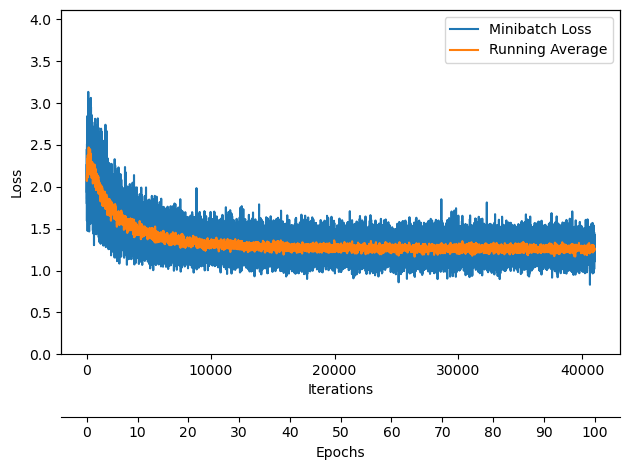

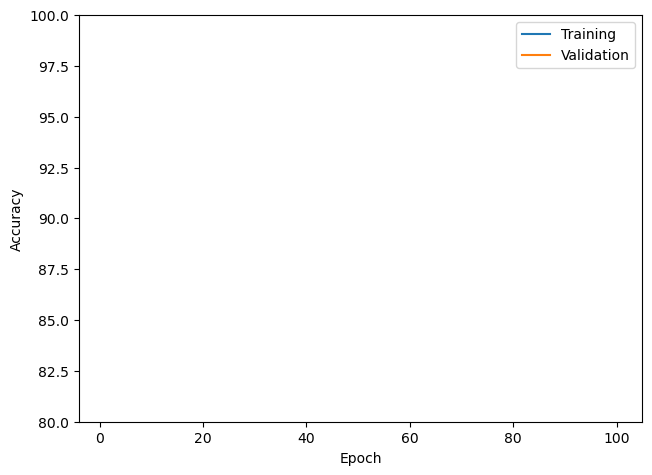

In [11]:
torch.manual_seed(RANDOM_SEED)
model = MLP(num_features=NUM_ATTRIBUTE,
                             num_hidden_1=NUM_HIDDEN_1,
                             drop_proba=0.5,
                             num_classes=NUM_CLASS)
model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

In [12]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, NUM_ATTRIBUTE).to(DEVICE)
            targets = targets.to(DEVICE)
            logits = net.forward(features)
            predicted_labels = torch.argmax(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    
print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Training Accuracy: 53.61
Test Accuracy: 51.65


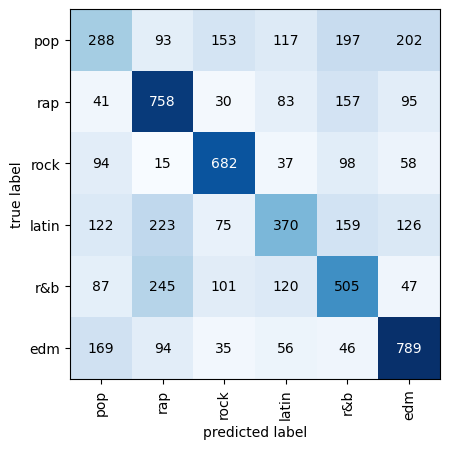

In [14]:
class_dict = {0: 'pop',
              1: 'rap',
              2: 'rock',
              3: 'latin',
              4: 'r&b',
              5: 'edm'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()